Loading velocity field from data files...
Grid size: 27 x 27 = 729 cells

Domain: L = 2.00 m, H = 2.00 m
dx = 0.076923 m, dy = 0.076923 m
Velocity range: U ∈ [-0.326, 1.121], V ∈ [-0.690, 0.224]

Boundary conditions:
Inlet A (left, y ≤ 0.1360): T = 20.0°C
Wall (right, y > 0.1360): T = 50.0°C

Starting ADI iteration...
Iteration    0: ε = 4.831939e-01, T ∈ [20.00, 29.00]°C
Iteration  100: ε = 1.377802e-01, T ∈ [20.00, 50.00]°C
Iteration  200: ε = 7.763377e-02, T ∈ [20.00, 50.00]°C
Iteration  300: ε = 4.764267e-02, T ∈ [20.00, 50.00]°C
Iteration  400: ε = 3.504627e-02, T ∈ [20.00, 50.00]°C
Iteration  500: ε = 2.943454e-02, T ∈ [20.00, 50.00]°C
Iteration  600: ε = 2.660127e-02, T ∈ [20.00, 50.00]°C
Iteration  700: ε = 2.488823e-02, T ∈ [20.00, 50.00]°C
Iteration  800: ε = 2.364081e-02, T ∈ [20.00, 50.00]°C
Iteration  900: ε = 2.259994e-02, T ∈ [20.00, 50.00]°C
Iteration 1000: ε = 2.166254e-02, T ∈ [20.00, 50.00]°C
Iteration 1100: ε = 2.078704e-02, T ∈ [20.00, 50.00]°C
Iteration 1200: ε = 

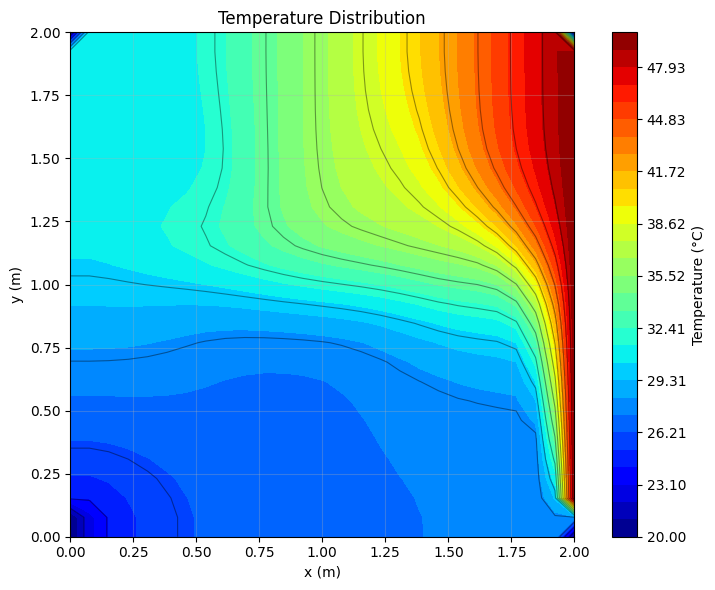


SIMULATION SUMMARY
Grid size: 27 x 27
Final temperature range: [20.00, 50.00] °C
Number of iterations: 5000
Final normalized residual: 4.317980e-03


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def tdma_solve(a, b, c, d):
    """
    Solves a tridiagonal system using Thomas algorithm (TDMA)
    """
    n = len(d)
    c_prime = np.zeros(n)
    d_prime = np.zeros(n)
    x = np.zeros(n)
    
    # Forward elimination
    c_prime[0] = c[0] / b[0] if abs(b[0]) > 1e-14 else 0.0
    d_prime[0] = d[0] / b[0] if abs(b[0]) > 1e-14 else 0.0
    
    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i-1]
        if abs(denom) < 1e-14:
            denom = 1e-14
        c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denom
    
    # Back substitution
    x[-1] = d_prime[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

# ============================================================================
# LOAD VELOCITY FIELD FROM FILES
# ============================================================================
print("Loading velocity field from data files...")

xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u_flat = np.loadtxt('u.dat')
v_flat = np.loadtxt('v.dat')

n = len(u_flat)
nx = int(np.sqrt(n))  
ny = n // nx          

print(f"Grid size: {nx} x {ny} = {n} cells")

# Reshape to 2D arrays (Fortran order, then transpose)
U = u_flat.reshape((ny, nx), order='F')
V = v_flat.reshape((ny, nx), order='F')

# Create coordinate arrays
x_min, x_max = xc.min(), xc.max()
y_min, y_max = yc.min(), yc.max()

L = x_max
H = y_max

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

print(f"\nDomain: L = {L:.2f} m, H = {H:.2f} m")
print(f"dx = {dx:.6f} m, dy = {dy:.6f} m")
print(f"Velocity range: U ∈ [{U.min():.3f}, {U.max():.3f}], V ∈ [{V.min():.3f}, {V.max():.3f}]")

# ============================================================================
# PHYSICAL PARAMETERS
# ============================================================================
rho = 1.0           
k = 1.0             
cp = 50.0           
Gamma = k / cp      

# Boundary conditions
T_A = 20.0          
T_wall = 50.0       

# Inlet/outlet heights
h_A = 0.068 * H     
h_C = 0.068 * H     

print(f"\nBoundary conditions:")
print(f"Inlet A (left, y ≤ {h_A:.4f}): T = {T_A}°C")
print(f"Wall (right, y > {h_C:.4f}): T = {T_wall}°C")

# ============================================================================
# TEMPERATURE FIELD INITIALIZATION
# ============================================================================
T = np.ones((nx, ny)) * T_A  

# ============================================================================
# SOLVER PARAMETERS
# ============================================================================
max_iter = 5000
tolerance = 0.001
alpha = 0.3         # Optimal under-relaxation factor
Pe_threshold = 2.0  

# ============================================================================
# ADI ITERATION LOOP
# ============================================================================
print("\nStarting ADI iteration...")
epsilon_history = []

for iteration in range(max_iter):
    T_old = T.copy()
    
    # ========================================================================
    # X-DIRECTION SWEEP
    # ========================================================================
    for j in range(1, ny-1):
        a = np.zeros(nx)
        b = np.zeros(nx)
        c = np.zeros(nx)
        d = np.zeros(nx)
        
        for i in range(1, nx-1):
            # Face velocities
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Convective fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusive conductances
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Peclet numbers
            Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 0.0
            Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 0.0
            Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 0.0
            Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 0.0
            
            # Hybrid scheme coefficients
            if abs(Pe_e) < Pe_threshold:
                a_E = D_e - 0.5 * F_e
            else:
                a_E = max(0.0, -F_e)
            
            if abs(Pe_w) < Pe_threshold:
                a_W = D_w + 0.5 * F_w
            else:
                a_W = max(0.0, F_w)
            
            if abs(Pe_n) < Pe_threshold:
                a_N = D_n - 0.5 * F_n
            else:
                a_N = max(0.0, -F_n)
            
            if abs(Pe_s) < Pe_threshold:
                a_S = D_s + 0.5 * F_s
            else:
                a_S = max(0.0, F_s)
            
            # Source term (lagged cross-direction)
            S = a_N * T[i, j+1] + a_S * T[i, j-1]
            
            # Central coefficient
            a_P = a_E + a_W + a_N + a_S
            
            # Assemble tridiagonal system
            a[i] = -a_W
            b[i] = a_P  
            c[i] = -a_E
            d[i] = S    
        
        # Left boundary (x = 0)
        b[0] = 1.0
        c[0] = 0.0
        if y[j] <= h_A:
            d[0] = T_A  
        else:
            b[0] = 1.0
            c[0] = -1.0
            d[0] = 0.0
        
        # Right boundary (x = L)
        a[-1] = 0.0
        b[-1] = 1.0
        if y[j] <= h_C:
            a[-1] = -1.0
            b[-1] = 1.0
            d[-1] = 0.0
        else:
            d[-1] = T_wall  
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        T[:, j] = alpha * T_new + (1.0 - alpha) * T[:, j]
    
    # ========================================================================
    # Y-DIRECTION SWEEP
    # ========================================================================
    for i in range(1, nx-1):
        a = np.zeros(ny)
        b = np.zeros(ny)
        c = np.zeros(ny)
        d = np.zeros(ny)
        
        for j in range(1, ny-1):
            # Face velocities
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Peclet
            Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 0.0
            Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 0.0
            Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 0.0
            Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 0.0
            
            # Hybrid scheme
            if abs(Pe_e) < Pe_threshold:
                a_E = D_e - 0.5 * F_e
            else:
                a_E = max(0.0, -F_e)
            
            if abs(Pe_w) < Pe_threshold:
                a_W = D_w + 0.5 * F_w
            else:
                a_W = max(0.0, F_w)
            
            if abs(Pe_n) < Pe_threshold:
                a_N = D_n - 0.5 * F_n
            else:
                a_N = max(0.0, -F_n)
            
            if abs(Pe_s) < Pe_threshold:
                a_S = D_s + 0.5 * F_s
            else:
                a_S = max(0.0, F_s)
            
            # Source (lagged x-direction)
            S = a_E * T[i+1, j] + a_W * T[i-1, j]
            
            a_P = a_E + a_W + a_N + a_S
            
            # Assemble
            a[j] = -a_S
            b[j] = a_P
            c[j] = -a_N
            d[j] = S
        
        # Bottom boundary (y = 0)
        a[0] = 0.0
        b[0] = 1.0
        c[0] = -1.0
        d[0] = 0.0
        
        # Top boundary (y = H)
        a[-1] = -1.0
        b[-1] = 1.0
        d[-1] = 0.0
        
        T_new = tdma_solve(a, b, c, d)
        T[i, :] = alpha * T_new + (1.0 - alpha) * T[i, :]
    
    # ========================================================================
    # CONVERGENCE CHECK
    # ========================================================================
    if iteration % 10 == 0:
        residual_sum = 0.0
        cell_count = 0
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                Pe_e = F_e / D_e if abs(D_e) > 1e-12 else 0.0
                Pe_w = F_w / D_w if abs(D_w) > 1e-12 else 0.0
                Pe_n = F_n / D_n if abs(D_n) > 1e-12 else 0.0
                Pe_s = F_s / D_s if abs(D_s) > 1e-12 else 0.0
                
                if abs(Pe_e) < Pe_threshold:
                    a_E = D_e - 0.5 * F_e
                else:
                    a_E = max(0.0, -F_e)
                
                if abs(Pe_w) < Pe_threshold:
                    a_W = D_w + 0.5 * F_w
                else:
                    a_W = max(0.0, F_w)
                
                if abs(Pe_n) < Pe_threshold:
                    a_N = D_n - 0.5 * F_n
                else:
                    a_N = max(0.0, -F_n)
                
                if abs(Pe_s) < Pe_threshold:
                    a_S = D_s + 0.5 * F_s
                else:
                    a_S = max(0.0, F_s)
                
                a_P = a_E + a_W + a_N + a_S
                
                residual = abs(a_E * T[i+1, j] + a_W * T[i-1, j] + 
                             a_N * T[i, j+1] + a_S * T[i, j-1] - a_P * T[i, j])
                
                residual_sum += residual
                cell_count += 1
        
        # Normalized residual
        Delta_T = abs(T_A - T_wall)
        f = rho * 1.0 * h_A * Delta_T
        
        if abs(f) > 1e-12:
            epsilon = residual_sum / f
        else:
            epsilon = residual_sum / cell_count
        
        epsilon_history.append(epsilon)
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration:4d}: ε = {epsilon:.6e}, T ∈ [{T.min():.2f}, {T.max():.2f}]°C")
        
        if epsilon < tolerance:
            print(f"\n✓ Converged at iteration {iteration}")
            print(f"  Normalized residual ε = {epsilon:.6e}")
            break

if iteration == max_iter - 1:
    print(f"\n⚠ Reached maximum iterations ({max_iter})")

# ============================================================================
# VISUALIZATION
# ============================================================================
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)
levels = np.linspace(T.min(), T.max(), 30)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='jet')
cbar = plt.colorbar(cf, ax=ax1, label='Temperature (°C)')
ax1.contour(X, Y, T.T, levels=15, colors='black', alpha=0.4, linewidths=0.8)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temperature_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)
print(f"Grid size: {nx} x {ny}")
print(f"Final temperature range: [{T.min():.2f}, {T.max():.2f}] °C")
print(f"Number of iterations: {iteration + 1}")
print(f"Final normalized residual: {epsilon:.6e}")
print("="*60)


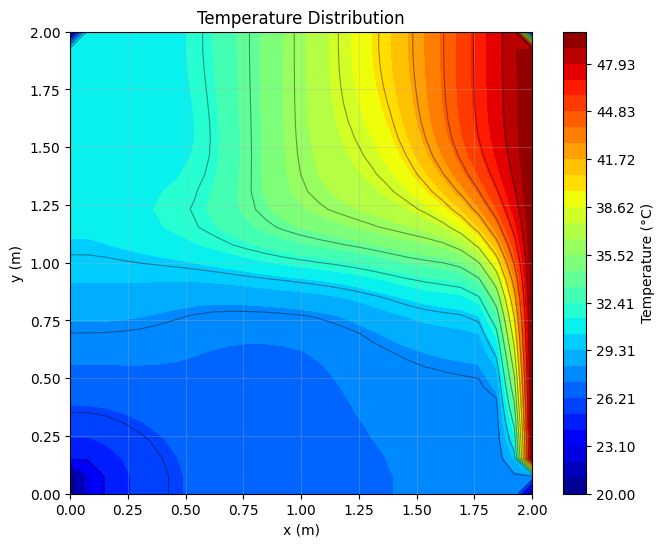

In [23]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)
levels = np.linspace(T.min(), T.max(), 30)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='jet')
cbar = plt.colorbar(cf, ax=ax1, label='Temperature (°C)')
ax1.contour(X, Y, T.T, levels=15, colors='black', alpha=0.4, linewidths=0.8)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)